## Generating the time-delay sample using SLSim

In this notebook, we generate samples of various sizes for the time-delay measurement project. The end result of this notebook is a csv generated with the following properties (at minimum):
* microlensing parameters
    * convergence: $\kappa$
    * stellar convergence: $\kappa_*$
    * shear: $\gamma$
* black hole accretion and transfer function parameters required by AMOEBA
    * black hole mass
    * eddington rate
    * black hole accretion disk inclination angle
* variability parameters required for a damped random walk generated using a bending power-law with fixed lower slope of 0 and higher slope of 2
    * $SF_\infty$ = $\sqrt2\sigma$ where $\sigma$ is the standard deviation of light curve variation from the mean
    * $\tau_{\rm DRW}$ where the breakpoint frequency = $1/\sqrt(2\pi\tau_{\rm DRW})$
* lensed magnitudes of 2/3/4 images
* arrival times of 2/3/4 images

### Import required pacakges

In [ ]:
### Cosmology and astropy packages
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity

### Arrays, tables, plots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### SLSim functions
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate
from slsim.Lenses.lens_pop import LensPop

from slsim.Util.param_util import ellipticity2phi_q

### Readin, readout, paths
from contextlib import redirect_stdout
import io
from tqdm import tqdm

### recompile packages after each edit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up SLSim to generate populations

In [133]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
galaxy_sky_area = Quantity(
    value=10, unit="deg2"
)  # this is the sky area over which galaxies are sampled
quasar_sky_area = Quantity(value=10, unit="deg2")

# this is the sky area over which lensed quasars are sampled
full_sky_area = Quantity(value=5000, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 4.0}

In [134]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=["u", "g", "r", "i", "z", "y"],
    cosmo=cosmo,
    z_min=0,
    z_max=4,
)

lens_galaxies_ell = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
    gamma_pl=dict(mean=2.0, std_dev=0.16),
)

In [135]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 4.00, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
# quasar sample with host galaxy
quasar_source_plus_galaxy = quasar_class.quasar_sample(
    m_min=15, m_max=28, host_galaxy=True
)

Matching quasars with host galaxies: 100%|██████████| 42363/42363 [00:12<00:00, 3262.32it/s]


In [136]:
# Prepare dictionary of agn variability kwargs
length_of_light_curve = 3850
variable_agn_kwarg_dict = {
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": 1,
    # "log_breakpoint_frequency": 1 / 20,
    # "low_frequency_slope": 1,
    # "high_frequency_slope": 3,
    # "standard_deviation": 0.9,
}
# variable_agn_kwarg_dict = {}
kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "u", "g", "r", "i", "z", "y"},
    "agn_driving_variability_model": "bending_power_law_from_distribution",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, length_of_light_curve, 1),
    "corona_height": 10,
    "r_resolution": 500,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "u", "g", "r", "i", "z", "y"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, length_of_light_curve, length_of_light_curve),
    "r_resolution": 500,
    "corona_height": 10,
}
# Initiate source population class.
source_quasar_plus_galaxies = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_source_plus_galaxy,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    catalog_type="skypy",
    point_source_type="quasar",
    extended_source_type="single_sersic",
    point_source_kwargs=kwargs_quasar,
)

In [137]:
# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop_ell = LensPop(
    deflector_population=lens_galaxies_ell,
    source_population=source_quasar_plus_galaxies,
    cosmo=cosmo,
    sky_area=full_sky_area,
)
### LSST cuts: 'u': 23.9,'g':25.0, 'r':24.7, 'i':24.0, 'z':23.3, 'y':22.1
kwargs_lens_cuts = {
    "min_image_separation": 0.7,
    "max_image_separation": 10,
    "second_brightest_image_cut": {"i": 23.3},
}
# drawing population
# the key difference in lens population drawing time is whether you ask for magnitude cuts or not I think?
quasar_lens_population = quasar_lens_pop_ell.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

Drawing lens population: 100%|██████████| 219702/219702 [00:28<00:00, 7654.86it/s]


In [ ]:
f = io.StringIO()
full_pop_df = pd.DataFrame()
with redirect_stdout(f):
    for i, lens_obj in enumerate(quasar_lens_population):
        full_pop_df = lens_obj.lens_to_dataframe(index=i, df=full_pop_df)
        for band in ["u", "g", "r", "i", "z", "y"]:
            full_pop_df.loc[i, f"ps_{band}_mag_true"] = lens_obj.point_source_magnitude(
                band=band, lensed=False
            )
        image2mag = full_pop_df.loc[i, "point_source_light_i_magnitude_1"]
        try:
            image3mag = full_pop_df.loc[i, "point_source_light_i_magnitude_2"]
        except KeyError:
            image3mag = 0
        second_or_third_mag = (
            image3mag if not (np.isnan(image3mag) or image3mag == 0) else image2mag
        )
        full_pop_df.loc[i, "i3"] = second_or_third_mag
        (
            full_pop_df.loc[i, "deflector_mass_phi"],
            full_pop_df.loc[i, "deflector_mass_q"],
        ) = ellipticity2phi_q(
            full_pop_df.loc[i, "deflector_mass_e1"],
            full_pop_df.loc[i, "deflector_mass_e2"],
        )
        (
            full_pop_df.loc[i, "deflector_light_phi"],
            full_pop_df.loc[i, "deflector_light_q"],
        ) = ellipticity2phi_q(
            full_pop_df.loc[i, "deflector_light_i_e1"],
            full_pop_df.loc[i, "deflector_light_i_e2"],
        )
        full_pop_df.loc[i, "deflector_stellar_mass"] = lens_obj.deflector_stellar_mass()
        full_pop_df.loc[i, "lens_obj"] = lens_obj

In [139]:
for i, lens_obj in enumerate(quasar_lens_population):
    full_pop_df.loc[i, "M_i"] = quasar_class.convert_magnitude(
        lens_obj.point_source_magnitude(band="i", lensed=False),
        full_pop_df.loc[i, "point_source_redshift"],
        conversion="apparent_to_absolute",
    )

### Applying a color offset to SLSim quasars

In [141]:
agile_quasars = pd.read_csv("MainNotebooks/agile_quasars.csv", index_col=0)
slsim_cols = [
    "point_source_redshift",
    "M_i",
    "ps_u_mag_true",
    "ps_g_mag_true",
    "ps_r_mag_true",
    "ps_i_mag_true",
    "ps_z_mag_true",
]

agile_colors = (
    pd.DataFrame(
        {
            "redshift": agile_quasars["z"],
            "i_mag": agile_quasars["M_i"],
            "u-g": agile_quasars["ps_mag_u"] - agile_quasars["ps_mag_g"],
            "g-r": agile_quasars["ps_mag_g"] - agile_quasars["ps_mag_r"],
            "r-i": agile_quasars["ps_mag_r"] - agile_quasars["ps_mag_i"],
            "i-z": agile_quasars["ps_mag_i"] - agile_quasars["ps_mag_z"],
        }
    )
    .dropna()
    .astype(np.float64)
)
color_samples = np.array(agile_colors).astype(np.float64)
computed_offsets = []

slsim_colors = (
    pd.DataFrame(
        {
            "redshift": full_pop_df["point_source_redshift"],
            "i_mag": full_pop_df["M_i"],
            "u-g": full_pop_df["ps_u_mag_true"] - full_pop_df["ps_g_mag_true"],
            "g-r": full_pop_df["ps_g_mag_true"] - full_pop_df["ps_r_mag_true"],
            "r-i": full_pop_df["ps_r_mag_true"] - full_pop_df["ps_i_mag_true"],
            "i-z": full_pop_df["ps_i_mag_true"] - full_pop_df["ps_z_mag_true"],
        }
    )
    .dropna()
    .astype(np.float64)
)

for df_ind in tqdm(slsim_colors.index):
    df_row = slsim_colors.loc[df_ind]
    sum_of_squared_differences = np.sum(
        (np.array(df_row[:2]) - color_samples[:, :2]) ** 2, axis=1
    )
    min_dist_ind = np.argmin(
        np.sqrt(np.array(sum_of_squared_differences, dtype="float"))
    )
    selected_sample = color_samples[min_dist_ind]
    computed_offsets.append(selected_sample)

computed_offsets = np.array(computed_offsets)
slsim_color_with_offset = pd.DataFrame()
slsim_color_with_offset["ps_i_mag_true"] = full_pop_df["ps_i_mag_true"]

slsim_color_with_offset["ps_r_mag_true"] = (
    slsim_color_with_offset["ps_i_mag_true"] + computed_offsets[:, 4]
)
slsim_color_with_offset["ps_g_mag_true"] = (
    slsim_color_with_offset["ps_r_mag_true"] + computed_offsets[:, 3]
)
slsim_color_with_offset["ps_u_mag_true"] = (
    slsim_color_with_offset["ps_g_mag_true"] + computed_offsets[:, 2]
)
slsim_color_with_offset["ps_z_mag_true"] = (
    full_pop_df["ps_i_mag_true"] - computed_offsets[:, 5]
)
slsim_color_with_offset["redshift"] = full_pop_df["point_source_redshift"]
slsim_color_with_offset["M_i"] = full_pop_df["M_i"]
full_pop_df[[f"ps_{band}_mag_true" for band in list("ugriz")]] = (
    slsim_color_with_offset[[f"ps_{band}_mag_true" for band in list("ugriz")]]
)

100%|██████████| 419/419 [00:00<00:00, 15337.87it/s]


### After applying color offsets, take a look at the sample properties:

#### Microlensing parameters

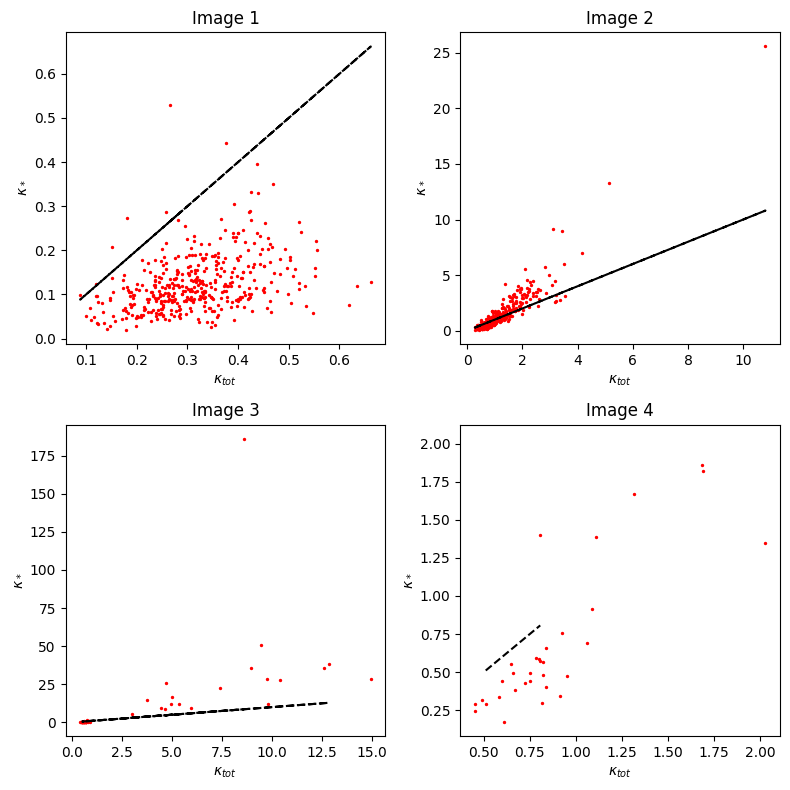

In [142]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(4):
    ax[i].scatter(
        full_pop_df[f"micro_kappa_tot_{i}"],
        full_pop_df[f"micro_kappa_star_{i}"],
        s=2,
        color="r",
    )
    ax[i].plot(
        full_pop_df[f"micro_kappa_tot_{i}"],
        full_pop_df[f"micro_kappa_tot_{i}"],
        ls="--",
        color="k",
    )
    ax[i].set_xlabel("$\kappa_{tot}$")
    ax[i].set_ylabel("$\kappa_*$")
    ax[i].set_title(f"Image {i+1}")
fig.tight_layout()

In [144]:
mks = []
mkt = []
counter_bad = []
# i'm gonna try pulling the function directly so that there's no trickling error from the df (i don' think there is but still)
for i, lens in enumerate(quasar_lens_population):
    kappa_star_images, kappa_tot_images, _, _ = (
        lens._microlensing_parameters_for_image_positions_single_source(
            band="i", source_index=0
        )
    )
    mks.append(kappa_star_images)
    mkt.append(kappa_tot_images)
    if np.sum(kappa_star_images > kappa_tot_images):
        print(kappa_star_images, kappa_tot_images, kappa_star_images > kappa_tot_images)
        counter_bad.append(i)

mks = np.concatenate(mks).flatten()
mkt = np.concatenate(mkt).flatten()

[0.10053619 0.17209786 0.69131268 1.66647473] [0.26328637 0.34204809 0.73347397 1.31359691] [False False False  True]
[0.0930451  4.01415375] [0.33404433 1.82837765] [False  True]
[ 0.09435795  1.84455513 12.05830957] [0.40413451 1.49730181 4.95265955] [False  True  True]
[0.13527754 0.98252361] [0.26473727 0.8570758 ] [False  True]
[0.08361243 0.57654372] [0.12288827 0.57280101] [False  True]
[0.10096314 1.49671597] [0.33052492 1.13433932] [False  True]
[0.1344128  0.86690962] [0.31727493 0.85831212] [False  True]
[0.10032703 0.93760606] [0.24674468 0.86641631] [False  True]
[0.10975916 2.08145407] [0.20373246 1.24517648] [False  True]
[0.09924232 2.01122784] [0.19283499 1.32676221] [False  True]
[0.10673205 1.42170295] [0.30856362 1.40265685] [False  True]
[0.09229988 1.9005428 ] [0.33272741 1.84654105] [False  True]
[0.09578038 3.20675012] [0.24566629 1.98587626] [False  True]
[0.08839893 1.65753817] [0.267941   1.07122394] [False  True]
[0.18957807 0.80097444] [0.31582857 0.7629304

In [145]:
len(counter_bad), len(quasar_lens_population)

(198, 419)

Text(0.5, 0.98, 'Kappa vs Kappa star for full sample')

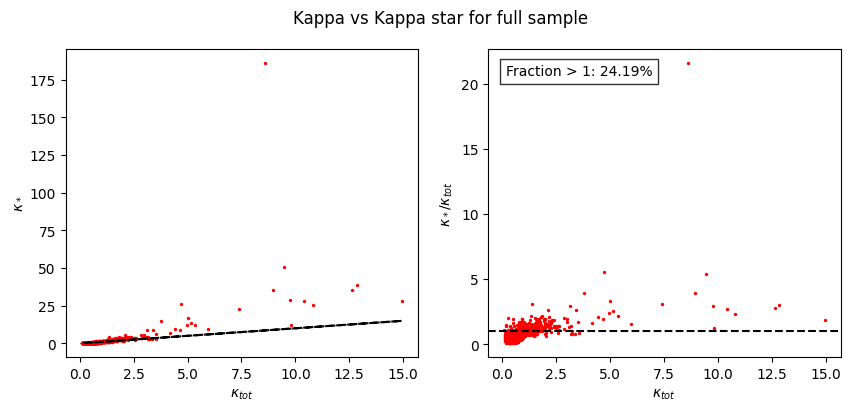

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(mkt, mks, s=2, color="r")
ax[0].set_xlabel("$\kappa_{tot}$")
ax[0].set_ylabel("$\kappa_*$")
ax[0].plot(mkt, mkt, ls="--", color="k")

ax[1].scatter(mkt, mks / mkt, s=2, color="r")
ax[1].set_xlabel("$\kappa_{tot}$")
ax[1].set_ylabel("$\kappa_* / \kappa_{tot}$")
ax[1].axhline(1, ls="--", color="k")
fraction = np.sum((mks / mkt) > 1) / len(mkt)
ax[1].text(
    0.05,
    0.95,
    f"Fraction > 1: {fraction:.2%}",
    transform=ax[1].transAxes,
    verticalalignment="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8),
)
fig.suptitle("Kappa vs Kappa star for full sample")

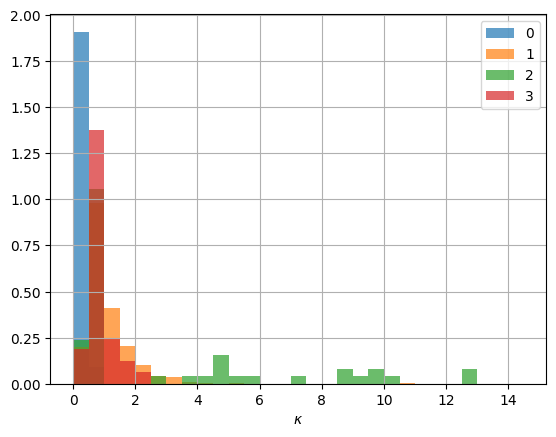

In [147]:
for i in range(4):
    bins = np.arange(0, 15, 0.5)
    full_pop_df[f"micro_kappa_tot_{i}"].hist(
        density=True, label=i, bins=bins, alpha=0.7
    )
plt.xlabel("$\kappa$")
plt.legend()